# 1. Load packages

The link to get [ImageAnalysis3](https://github.com/zhengpuas47/ImageAnalysis3) 

or the Zhuang lab archived [source_tools](https://github.com/ZhuangLab/Chromatin_Analysis_2020_cell/tree/master/sequential_tracing/source)

In [1]:
%run "C:\Users\shiwei\Documents\ImageAnalysis3\required_files\Startup_py3.py"
sys.path.append(r"C:\Users\shiwei\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

import pandas as pd

43052


See **functions** in the repository for [AnalysisTool_Chromatin](../../functions/README.md)

In [2]:
# Chromatin_analysis_tools (ATC)
# Get path for the py containing functions
import os
import sys
import importlib
module_path =r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin'
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import relevant modules
import gene_selection 
importlib.reload(gene_selection)
import gene_to_loci
importlib.reload(gene_to_loci)
import gene_activity
importlib.reload(gene_activity)
import loci_1d_features
importlib.reload(loci_1d_features)  

import atac_to_loci
importlib.reload(atac_to_loci)

<module 'atac_to_loci' from 'C:\\Users\\shiwei\\Documents\\AnalysisTool_Chromatin\\atac_to_loci.py'>

In [3]:
import seaborn as sns
import scanpy as sc
import numpy as np

## 1.1 Define output folder

In [4]:
output_main_folder = r'L:\Shiwei\Figures\MOp_draft_2023_v2\Nuclear_organization_v2'
output_analysis_folder = os.path.join(output_main_folder, 'analysis')
output_figure_folder = os.path.join(output_main_folder, 'figures')

make_output_folder = True

if make_output_folder and not os.path.exists(output_analysis_folder):
    os.makedirs(output_analysis_folder)
    print(f'Generating analysis folder: {output_analysis_folder}.')
elif os.path.exists(output_analysis_folder):
    print(f'Use existing analysis folder: {output_analysis_folder}.')
    
if make_output_folder and not os.path.exists(output_figure_folder):
    os.makedirs(output_figure_folder)
    print(f'Generating figure folder: {output_figure_folder}.')
elif os.path.exists(output_figure_folder):
    print(f'Use existing figure folder: {output_figure_folder}.')

Use existing analysis folder: L:\Shiwei\Figures\MOp_draft_2023_v2\Nuclear_organization_v2\analysis.
Use existing figure folder: L:\Shiwei\Figures\MOp_draft_2023_v2\Nuclear_organization_v2\figures.


## 1.2 setting up plotting parameters

In [5]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

import matplotlib
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42

plt.rc('font', family='serif')
plt.rc('font', serif='Arial')


# Other required plotting parameters
_dpi = 300
_font_size = 7.5
_page_width = 5.5

from ImageAnalysis3.figure_tools import _double_col_width, _single_col_width, _ticklabel_size,_ticklabel_width

import seaborn as sns
sns.set_context("paper", rc={"font.size":_font_size,"axes.titlesize":_font_size+1,"axes.labelsize":_font_size})   

In [6]:
selected_cell_labels = ['L2/3 IT','L4/5 IT','L5 IT','L6 IT','L5 ET','L5/6 NP','L6 CT','L6b',
                           'Sst','Pvalb','Lamp5','Sncg','Vip',
                           'Astro','Oligo','OPC','Micro','Endo','VLMC','SMC','Peri', 
                           #'other',
                          ]

celltype_palette = {'Astro':'lightcoral', 
                    'Endo':'skyblue', 
                    'L2/3 IT':'gold', 
                    'L4/5 IT':'darkorange', 
                    'L5 ET':'mediumseagreen', 
                    'L5 IT':'aqua',
                    'L5/6 NP':'darkgreen',
                    'L6 CT':'brown',
                    'L6 IT':'magenta',
                    'L6b':'blue', 
                    'Lamp5':'orange', 
                    'Micro':'peachpuff',
                    'OPC':'thistle', 
                    'Oligo':'darkviolet',
                    'Peri':'sandybrown',
                    'Pvalb':'springgreen',
                    'SMC':'rosybrown',
                    'Sncg':'darkkhaki',
                    'Sst':'steelblue', 
                    'VLMC':'saddlebrown', 
                    'Vip':'red',
                    'other':'slategray'}



# 2. Load codebook and chr2Zxys

## Codebook

Example of [codebook](../../postanalysis/0_locus_annotation/resources/MERFISH_loci_adjacent_genes_tss_more_res.csv)

In [7]:
# load codebook
# L drive is Crick Pu_SSD_0
codebook_save_folder=r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_20230201\postanalysis_vCW2_sorted'

# Load sorted codebook (allows direct matrix slicing) with cell type info
# Load codebook (then sort to allow direct matrix slicing) with cell type info

codebook_fname = os.path.join(codebook_save_folder,'MERFISH_loci_adjacent_genes_tss_more_res.csv')
codebook_df = pd.read_csv (codebook_fname, index_col=0)

# sort df temporailiy so matrix can be sliced by df order directly
codebook_df = loci_1d_features.sort_loci_df_by_chr_order (codebook_df)

codebook_df.head()

,name,id,chr,chr_order,library,dtype,adjacent_genes_0kb_tss,adjacent_genes_10kb_tss,adjacent_genes_50kb_tss,adjacent_genes_100kb_tss,adjacent_genes_200kb_tss,adjacent_genes_500kb_tss,adjacent_genes_1000kb_tss,adjacent_genes_1500kb_tss,adjacent_genes_2000kb_tss
loci_name,,,,,,,,,,,,,,,
chr1_3742742_3759944,1:3742742-3759944,1,1,0,CTP11,combo,intergenic,intergenic,intergenic,Xkr4,Xkr4,Gm18956; Gm7341; Xkr4,Gm18956; Gm2053; Gm6085; Gm6101; Gm6119; Gm734...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...
chr1_6245958_6258969,1:6245958-6258969,2,1,1,CTP11,combo,intergenic,intergenic,4732440D04Rik; Rb1cc1,4732440D04Rik; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Npbwr1; Rb1cc1...,4732440D04Rik; Gm19026; Gm2147; Gm5694; Gm7182...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...
chr1_8740008_8759916,1:8740008-8759916,3,1,2,CTP11,combo,intergenic,intergenic,Gm15452,Gm15452,Gm15452,Gm15452,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm15452;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...
chr1_9627926_9637875,1:9627926-9637875,1,1,3,CTP13,combo,2610203C22Rik,2610203C22Rik,2610203C22Rik,2610203C22Rik; Adhfe1; Gm6161; Mybl1; Rrs1,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm18300;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Cops5; C...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...
chr1_9799472_9811359,1:9799472-9811359,2,1,4,CTP13,combo,Gm6195,Gm6195; Sgk3,Gm6195; Sgk3,1700034P13Rik; Gm6195; Mcmdc2; Mybl1; Sgk3; Vc...,1700034P13Rik; 2610203C22Rik; Gm6195; Mcmdc2; ...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...


# 3. Load summarized RNAseq for imaged loci

 Data can be generated by the notebook:

 [0_locus_annotation/scripts/4_subclass_atac_and_rna_means_by_loci](../0_locus_annotation/scripts/4_subclass_atac_and_rna_means_by_loci.ipynb)

In [9]:
import tqdm

rna_summary_folder = r'L:\Shiwei\Figures\MOp_draft_2023_v2\AB_compartment\analysis'

sel_class_list =celltype_palette.keys()


ref_measure_dict_byGroup = {}

for _class in tqdm.tqdm(sel_class_list):
    _class_name = _class.replace(' ','_').replace('/','_')
    #print(_class_name)
    rna_atac_fname = os.path.join(rna_summary_folder,f'subclass_{_class_name}_snATAC_snRNA_mean_by_loci.csv')
    if os.path.exists(rna_atac_fname):
        rna_atac_df = pd.read_csv(rna_atac_fname,index_col=1)
        ref_measure_dict_byGroup[_class] = rna_atac_df

100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 66.71it/s]


In [10]:
rna_atac_df

,Unnamed: 0,mean_rna_2X_2000kb,mean_rna_2X_200kb,mean_rna_2X_50kb
loci_name,,,,
chr1_3742742_3759944,0,14.736264,12.552198,0.000000
chr1_6245958_6258969,1,5.254579,1.544872,1.544872
chr1_8740008_8759916,2,28.511905,0.000000,0.000000
chr1_9627926_9637875,3,33.426740,0.657509,0.000000
chr1_9799472_9811359,4,33.426740,0.854396,0.163004
...,...,...,...,...
chrX_166247682_166259932,1977,4.434066,2.259158,1.935897
chrX_167157164_167167452,1978,32.402015,0.265568,0.265568
chrX_168746045_168757590,1979,29.576007,28.240842,0.184066


# 4. Load summarized radial position

Data can be generated by the notebook

[1_radial_position_convexhull_singlecell_dataframe](1_radial_position_convexhull_singlecell_dataframe.ipynb)

In [11]:
min_pts_th = 600
output_fname = os.path.join(output_analysis_folder, f'radial_pos_convexhull_median_summary_{min_pts_th}pts_bysubclass_v2.csv')

sorted_median_radial_pos_all = pd.read_csv(output_fname, index_col=0)
sorted_median_radial_pos_all.head()

,chr,chr_order,norm_radial_position,total_cell,subclass
loci_name,,,,,
chr1_3742742_3759944,1,0,0.860136,1022.0,L2/3 IT
chr1_6245958_6258969,1,1,0.855358,969.0,L2/3 IT
chr1_8740008_8759916,1,2,0.850017,628.0,L2/3 IT
chr1_9627926_9637875,1,3,0.839728,960.0,L2/3 IT
chr1_9799472_9811359,1,4,0.826204,900.0,L2/3 IT


In [12]:
#rna_summary_df = pd.DataFrame(index = rna_df_dict['L2/3 IT'].index)
rna_summary_dict = {'rna_200kb':[],'rna_2000kb':[],'rna_50kb':[],
                    'loci':[],'celltype':[],'chr':[],'norm_radial_position':[],'total_cell':[],}
for _group, _rna_df in ref_measure_dict_byGroup.items():
    #rna_summary_dict['rna'].extend(_rna_df['log10p_mean_rna'].tolist())
    #rna_summary_dict['rna'].extend(_rna_df['mean_rna'].tolist())
    rna_summary_dict['rna_200kb'].extend(_rna_df['mean_rna_2X_200kb'].tolist())
    rna_summary_dict['rna_2000kb'].extend(_rna_df['mean_rna_2X_2000kb'].tolist())
    rna_summary_dict['rna_50kb'].extend(_rna_df['mean_rna_2X_50kb'].tolist())
    rna_summary_dict['loci'].extend(_rna_df.index.tolist())
    rna_summary_dict['celltype'].extend([_group]*len(_rna_df))
    rna_summary_dict['chr'].extend([i.split('_')[0] for i in _rna_df.index.tolist()])
    
    group_radial_pos_all = sorted_median_radial_pos_all[sorted_median_radial_pos_all['subclass']==_group]
    if len(group_radial_pos_all)==len(_rna_df):
        group_radial_pos_all = group_radial_pos_all.loc[_rna_df.index]
        radial_pos_list = group_radial_pos_all['norm_radial_position'].tolist()
        radial_N_list = group_radial_pos_all['total_cell'].tolist()
    else:
        radial_pos_list = [np.nan]*len(_rna_df)
        radial_N_list = [np.nan]*len(_rna_df)
        
    rna_summary_dict['norm_radial_position'].extend(radial_pos_list)
    rna_summary_dict['total_cell'].extend(radial_N_list)
    
    
rna_summary_df = pd.DataFrame(rna_summary_dict)
rna_summary_df

,rna_200kb,rna_2000kb,rna_50kb,loci,celltype,chr,norm_radial_position,total_cell
0,0.325153,9.202454,0.000000,chr1_3742742_3759944,Astro,chr1,0.831239,1020.0
1,1.196319,11.447853,1.196319,chr1_6245958_6258969,Astro,chr1,0.785055,807.0
2,0.000000,6.288344,0.000000,chr1_8740008_8759916,Astro,chr1,0.836495,563.0
3,2.306748,13.969325,0.000000,chr1_9627926_9637875,Astro,chr1,0.764242,826.0
4,0.815951,13.969325,0.325153,chr1_9799472_9811359,Astro,chr1,0.750467,770.0
...,...,...,...,...,...,...,...,...
35671,2.259158,4.434066,1.935897,chrX_166247682_166259932,Vip,chrX,0.814361,61.0
35672,0.265568,32.402015,0.265568,chrX_167157164_167167452,Vip,chrX,0.796547,54.0
35673,28.240842,29.576007,0.184066,chrX_168746045_168757590,Vip,chrX,0.794884,51.0
35674,0.000000,29.202381,0.000000,chrX_169963295_170005197,Vip,chrX,0.775328,78.0


## define activity to categories

In [13]:
#active_th = np.percentile(rna_summary_df['rna'], 50)
#assign_rna_by_absolute = True
h_p = 75
l_p = 25

for _col in ['rna_50kb', 'rna_200kb','rna_2000kb'][-1:]:
    #if assign_rna_by_absolute: # assign using the percentile including all celltypes
    _method = 'abs'
    active_th_h = np.percentile(rna_summary_df[_col], h_p)
    active_th_l = np.percentile(rna_summary_df[_col], l_p)
    #print(active_th_h)
    #print(active_th_l)
    #rna_summary_df['activity'] = rna_summary_df['rna']>active_th
    rna_summary_df.loc[rna_summary_df[_col]>active_th_h,f'{_method}_{_col}_activity'] = 'high' 
    rna_summary_df.loc[rna_summary_df[_col]<=active_th_l,f'{_method}_{_col}_activity'] = 'low' 
    rna_summary_df.loc[(rna_summary_df[_col]<=active_th_h) & 
                       (rna_summary_df[_col]>active_th_l),f'{_method}_{_col}_activity'] = 'intermediate' 

    # assign individually by celltype
    _method = 'rel'
    for _class in tqdm.tqdm(sel_class_list):
        if _class in np.unique(rna_summary_df['celltype']):
            sel_rna_summary_df = rna_summary_df[rna_summary_df['celltype']==_class]
            active_th_h = np.percentile(sel_rna_summary_df[_col], h_p)
            active_th_l = np.percentile(sel_rna_summary_df[_col], l_p)
            #print(active_th_h)
            #print(active_th_l)
            #rna_summary_df['activity'] = rna_summary_df['rna']>active_th
            rna_summary_df.loc[(rna_summary_df['celltype']==_class)&
                               (rna_summary_df[_col]>active_th_h),f'{_method}_{_col}_activity'] = 'high' 
            rna_summary_df.loc[(rna_summary_df['celltype']==_class)&
                               (rna_summary_df[_col]<=active_th_l),f'{_method}_{_col}_activity'] = 'low' 
            rna_summary_df.loc[(rna_summary_df['celltype']==_class)&
                               (rna_summary_df[_col]<=active_th_h) & 
                               (rna_summary_df[_col]>active_th_l),f'{_method}_{_col}_activity'] = 'intermediate' 

rna_summary_df

100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 36.68it/s]


,rna_200kb,rna_2000kb,rna_50kb,loci,celltype,chr,norm_radial_position,total_cell,abs_rna_2000kb_activity,rel_rna_2000kb_activity
0,0.325153,9.202454,0.000000,chr1_3742742_3759944,Astro,chr1,0.831239,1020.0,intermediate,intermediate
1,1.196319,11.447853,1.196319,chr1_6245958_6258969,Astro,chr1,0.785055,807.0,intermediate,high
2,0.000000,6.288344,0.000000,chr1_8740008_8759916,Astro,chr1,0.836495,563.0,intermediate,intermediate
3,2.306748,13.969325,0.000000,chr1_9627926_9637875,Astro,chr1,0.764242,826.0,intermediate,high
4,0.815951,13.969325,0.325153,chr1_9799472_9811359,Astro,chr1,0.750467,770.0,intermediate,high
...,...,...,...,...,...,...,...,...,...,...
35671,2.259158,4.434066,1.935897,chrX_166247682_166259932,Vip,chrX,0.814361,61.0,low,low
35672,0.265568,32.402015,0.265568,chrX_167157164_167167452,Vip,chrX,0.796547,54.0,high,high
35673,28.240842,29.576007,0.184066,chrX_168746045_168757590,Vip,chrX,0.794884,51.0,high,high
35674,0.000000,29.202381,0.000000,chrX_169963295_170005197,Vip,chrX,0.775328,78.0,high,high


# 5. Plot histogram for each type

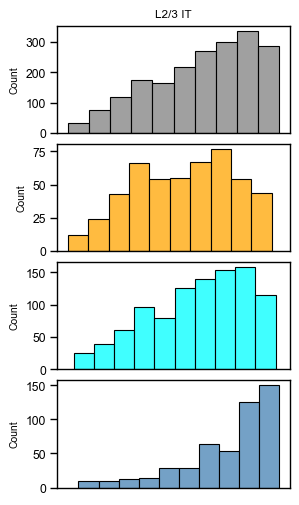

In [14]:
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
activity_col = 'rel_rna_2000kb_activity'
#activity_col = 'abs_rna_2000kb_activity'
rna_col = 'rna_2000kb'
hist_bins = 10

for _celltype in ['L2/3 IT','Oligo', 'Micro'][:1]:

    plot_df = rna_summary_df[rna_summary_df['celltype']==_celltype]
    plot_df = plot_df[plot_df['chr']!='chrY']
    
    fig,ax1=plt.subplots(figsize=(3,6),dpi=100)
    ax1.grid(False)
    sns.histplot(data=plot_df, x='norm_radial_position',bins=hist_bins, ax=ax1, color='gray')
    ax1.set_title(_celltype)
    
    divider = make_axes_locatable(ax1)
    _type_colors = ['orange','cyan','steelblue']
    for _type_idx, _type in enumerate(['high','intermediate','low']):
        sel_plot_df = plot_df[plot_df[activity_col]== _type]
        bot_ax = divider.append_axes('bottom', size='100%', pad="10%", 
                                     sharex=ax1, xticks=[])
        sns.histplot(data=sel_plot_df, x='norm_radial_position',bins=hist_bins, ax=bot_ax, color = _type_colors[_type_idx],)
        bot_ax.grid(False)
        
    


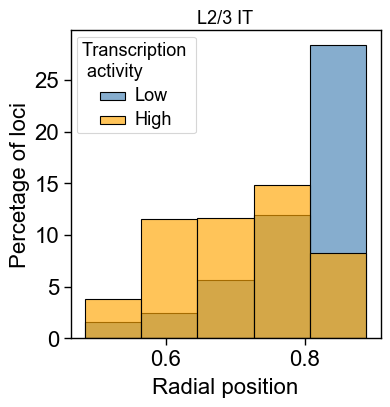

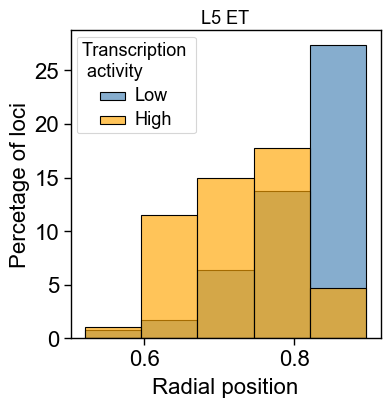

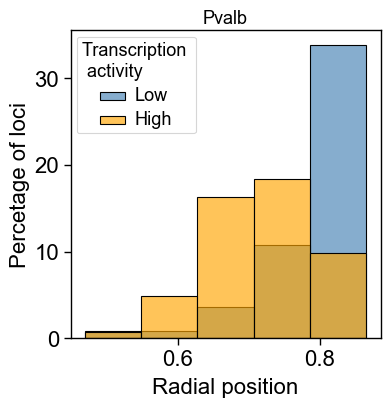

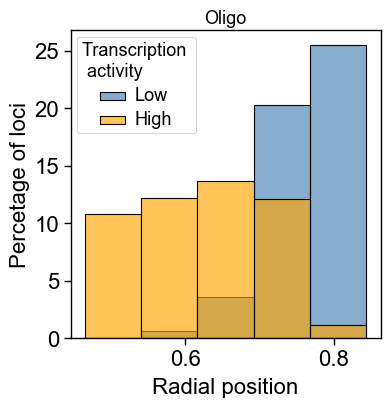

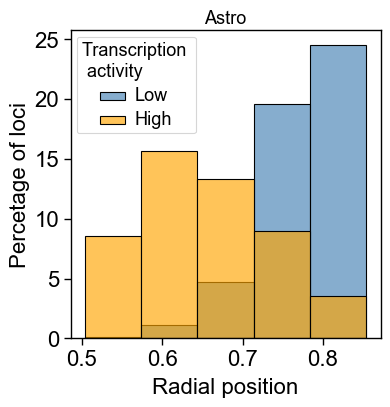

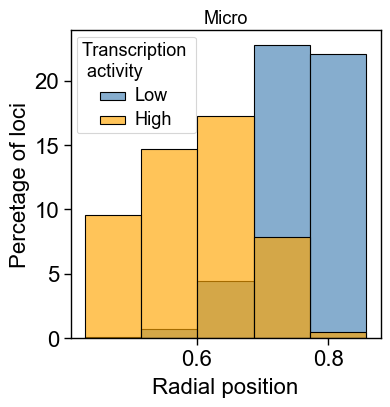

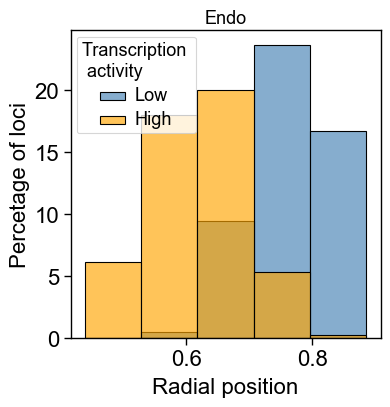

In [15]:
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
activity_col = 'rel_rna_2000kb_activity'
#activity_col = 'abs_rna_2000kb_activity'
rna_col = 'rna_2000kb'
hist_bins = 5

for _celltype in ['L2/3 IT','L5 ET','Pvalb','Oligo', 'Astro','Micro','Endo'][:]:

    plot_df = rna_summary_df[rna_summary_df['celltype']==_celltype]
    plot_df = plot_df[plot_df['chr']!='chrY']
    
    fig,ax=plt.subplots(figsize=(4,4),dpi=100)
    ax.grid(False)
    #sns.histplot(data=plot_df, x='norm_radial_position',bins=hist_bins, ax=ax1, 
                 #color='gray', alpha=0.1, stat='density')
    ax.set_title(_celltype)
    
    divider = make_axes_locatable(ax1)
    _type_colors = {'high':'orange','low':'steelblue','intermediate':'cyan'}
    #for _type_idx, _type in enumerate(['high','low']):
    sel_plot_df = plot_df[plot_df[activity_col]!='intermediate']
    #sel_plot_df = plot_df.copy(deep=True)
    gfg = sns.histplot(data=sel_plot_df, x='norm_radial_position',bins=hist_bins, 
                       hue =activity_col,hue_order = ['high','low'],
                     ax=ax,palette = _type_colors, stat='percent', 
                       common_norm=True, alpha=0.65)
    
    #ax.legend(activity_col).set_title('A')
    #sns.move_legend(ax, "upper left", #bbox_to_anchor=(0.5, 1.15), 
                    #ncol=1)
    # for legend text
    plt.legend(title='Transcription \n activity', loc='upper left', alignment= 'center',
               labels=['Low', 'High'])
    plt.setp(gfg.get_legend().get_texts(), fontsize='13') 
    # for legend title
    plt.setp(gfg.get_legend().get_title(), fontsize='13') 



    #plt.ylim([0.45,0.99])
    ax.set_ylabel(f"Percetage of loci", fontsize=16, rotation=90,labelpad=3,)
    ax.set_xlabel(f"Radial position", fontsize=16, rotation=0,labelpad=5,)
    ax.tick_params('both',labelsize=16)
    #plt.xticks(rotation=90)

    #select_chroms_plot = [str(i) for i in range(1,20)]
    #select_chroms_plot.append('X')
    #ax.set_xticks(np.arange(0,len(select_chroms_plot)))
    #TickLabels = select_chroms_plot
    #ax.set_xticklabels(TickLabels,rotation=0,fontdict={'fontsize':10})

    #ax.axhline(0.7, 0, 20, color='crimson', linestyle='dashed', linewidth=1.5)
    ax.set_title(_celltype,fontsize=13,pad=5)
    ax.grid(False)

    #ax.set_yticklabels(TickLabels,rotation=0,fontdict={'fontsize':12})
    _celltype_fname = _celltype.replace('/','_').replace(' ','_')
    #plt.savefig(os.path.join(output_figure_folder, f'Histplot_radial_by_{activity_col}_{_celltype_fname}.pdf'), 
                #transparent=True, dpi=300, bbox_inches='tight')   
    plt.show()

        
    


# 6. Plot scatter between loci and positioning

## binned measurements

In [16]:
rna_summary_df

,rna_200kb,rna_2000kb,rna_50kb,loci,celltype,chr,norm_radial_position,total_cell,abs_rna_2000kb_activity,rel_rna_2000kb_activity
0,0.325153,9.202454,0.000000,chr1_3742742_3759944,Astro,chr1,0.831239,1020.0,intermediate,intermediate
1,1.196319,11.447853,1.196319,chr1_6245958_6258969,Astro,chr1,0.785055,807.0,intermediate,high
2,0.000000,6.288344,0.000000,chr1_8740008_8759916,Astro,chr1,0.836495,563.0,intermediate,intermediate
3,2.306748,13.969325,0.000000,chr1_9627926_9637875,Astro,chr1,0.764242,826.0,intermediate,high
4,0.815951,13.969325,0.325153,chr1_9799472_9811359,Astro,chr1,0.750467,770.0,intermediate,high
...,...,...,...,...,...,...,...,...,...,...
35671,2.259158,4.434066,1.935897,chrX_166247682_166259932,Vip,chrX,0.814361,61.0,low,low
35672,0.265568,32.402015,0.265568,chrX_167157164_167167452,Vip,chrX,0.796547,54.0,high,high
35673,28.240842,29.576007,0.184066,chrX_168746045_168757590,Vip,chrX,0.794884,51.0,high,high
35674,0.000000,29.202381,0.000000,chrX_169963295_170005197,Vip,chrX,0.775328,78.0,high,high


meta NOT subset; don't know how to subset; dropped


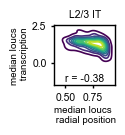

meta NOT subset; don't know how to subset; dropped


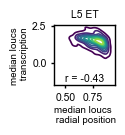

meta NOT subset; don't know how to subset; dropped


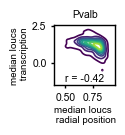

meta NOT subset; don't know how to subset; dropped


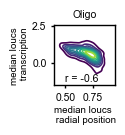

meta NOT subset; don't know how to subset; dropped


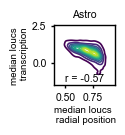

meta NOT subset; don't know how to subset; dropped


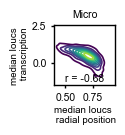

meta NOT subset; don't know how to subset; dropped


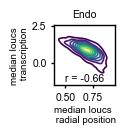

In [18]:
%matplotlib inline
from scipy.stats import linregress, pearsonr, spearmanr

from mpl_toolkits.axes_grid1 import make_axes_locatable
activity_col = 'rel_rna_2000kb_activity'
#activity_col = 'abs_rna_2000kb_activity'
rna_col = 'rna_2000kb'
hist_bins = 5

for _celltype in ['L2/3 IT','L5 ET','Pvalb','Oligo', 'Astro','Micro','Endo'][:]:

    plot_df = rna_summary_df[rna_summary_df['celltype']==_celltype]
    plot_df = plot_df[(plot_df['chr']!='chrY') ]
    #plot_df[f'log10_{rna_col}'] = np.log10(plot_df[rna_col]+.01)
    plot_df = plot_df[plot_df[rna_col]>0]
    plot_df[f'log10_{rna_col}'] = np.log10(plot_df[rna_col])
    
    fig,ax =plt.subplots(figsize=(_page_width/7,_page_width/7),dpi=100)
    ax.grid(False)

    ax.set_title(_celltype)
    
    #divider = make_axes_locatable(ax1)
    _type_colors = {'high':'orange','low':'steelblue','intermediate':'cyan'}
    #for _type_idx, _type in enumerate(['high','low']):
    sel_plot_df = plot_df.copy(deep=True)
    #sel_plot_df = plot_df.copy(deep=True)
    gfg = sns.kdeplot(data=sel_plot_df, x='norm_radial_position',y=f'log10_{rna_col}',
                       levels= hist_bins*2,
                      ax=ax, fill=False, cmap='viridis', #alpha = 0.6, #bins = hist_bins*2,kind="kde"
                     )
    # calculate color
    #sel_plot_df = sel_plot_df[sel_plot_df['ave_rna_log10']>-0.5]
    values = np.vstack([sel_plot_df['norm_radial_position'], sel_plot_df[f'log10_{rna_col}']])
    kernel = scipy.stats.gaussian_kde(values)(values)
    vmin,vmax = scipy.stats.scoreatpercentile(kernel,10),scipy.stats.scoreatpercentile(kernel,90)
    
    # plot
    #gfg = sns.scatterplot(data=sel_plot_df, x='norm_radial_position',y=f'log10_{rna_col}', 
                           #c=kernel, cmap='plasma', vmin=vmin, vmax=vmax,
                           #linewidth=0, s=5,rasterized=True,
                           #ax=ax)
    corr, p = spearmanr(sel_plot_df['norm_radial_position'], sel_plot_df[f'log10_{rna_col}'])
    #ax.annotate(f'{round(corr,2)}',xy=(0.1,2.1), fontsize=13)
    
    ax.annotate(f'r = {round(corr,2)}',xy=(0.5,-1.3), fontsize=_font_size)

    plt.ylim([-1.5,2.6])
    plt.xlim([0.4,0.95])
    ax.set_ylabel(f"median loucs \n transcription", fontsize=_font_size-0.5, rotation=90,labelpad=2,)
    ax.set_xlabel(f"median loucs \n radial position", fontsize=_font_size-0.5, rotation=0,labelpad=2,)
    ax.tick_params('both',labelsize=_font_size, length=_ticklabel_size)
    #plt.xticks(rotation=90)

    #select_chroms_plot = [str(i) for i in range(1,20)]
    #select_chroms_plot.append('X')
    #ax.set_xticks(np.arange(0,len(select_chroms_plot)))
    #TickLabels = select_chroms_plot
    #ax.set_xticklabels(TickLabels,rotation=0,fontdict={'fontsize':10})

    #ax.axhline(0.7, 0, 20, color='crimson', linestyle='dashed', linewidth=1.5)
    ax.set_title(_celltype,fontsize=_font_size,pad=5)
    ax.grid(False)

    #ax.set_yticklabels(TickLabels,rotation=0,fontdict={'fontsize':12})
    _celltype_fname = _celltype.replace('/','_').replace(' ','_')
    plt.savefig(os.path.join(output_figure_folder, f'Displot_radial_by_{activity_col}_{_celltype_fname}.pdf'), 
                transparent=True, dpi=300, bbox_inches='tight')   
    plt.show()

        
    
